In [1]:
# testing save status
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tensorflow.keras.regularizers import l2, l1,L1L2
from sklearn.utils import shuffle

from kerastuner.tuners import Hyperband
# import mlp classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# import metrics
from sklearn.metrics import classification_report, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import initializers
from keras.layers import BatchNormalization
from tensorflow.keras.constraints import MaxNorm

from tensorflow.keras.optimizers import Adam

import shap
from lime import lime_tabular

from transformers import AutoTokenizer, TFAutoModel

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # disables some tensorflow warnings

/Users/andrewbennett/Documents/bse/term2/comp_learning_deep_learning/test2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ModuleNotFoundError: No module named 'kerastuner'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 262713923891067296
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15510929408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 636748584313781856
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train = pd.read_csv('train_cleaned_2.csv')
test = pd.read_csv('test_cleaned_2.csv')


In [6]:
train.head()

,los,all_text,marital_status_7,code39,code36,code35,code38,code34,code37,ethnicity_7,...,age,sp_o2_min,marital_status_2,resp_rate_min,ethnicity_1,temp_c_max,heart_rate_mean,insurance,sp_o2_max,heart_rate_min
0,4.5761,"Hemorrhage of gastrointestinal tract, unspecif...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.325039,-0.017890,-0.928031,0.883151,0.601965,-0.591043,2.453325,0.358506,-0.388530,1.361467
1,0.7582,Eosinophilic esophagitis Foreign body in esoph...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.285873,0.640864,1.077550,0.297049,0.601965,-1.025250,-0.409674,-0.022086,0.416161,-0.456105
2,3.7626,Perforation of intestine Other suppurative per...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.209974,0.797230,-0.928031,0.297049,-1.661227,-0.663411,0.448834,0.358506,0.416161,0.802214
3,3.8734,Diaphragmatic hernia without mention of obstru...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.612702,-1.123457,-0.928031,0.003998,0.601965,2.737883,0.938282,0.358506,0.416161,0.452681
4,5.8654,Diverticulitis of colon (without mention of he...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.842832,-0.369324,-0.928031,-0.230442,0.601965,-0.243677,-0.371402,0.358506,-0.712662,-0.533002


In [7]:
# drop code cols
code_cols = [col for col in train.columns if 'code' in col]
train.drop(columns=code_cols, inplace=True)
test.drop(columns=code_cols, inplace=True)

In [8]:
train = train.dropna()

train_features = train.copy()

train_labels = train_features.pop('los')

text_features =  train_features.pop('all_text')

### Model V1

For the initial model, I tried out everything from the notebook.

* I started with a Normalization layer for the inputs which scales the input features to have zero mean and a standard deviation of 1.
* Then I add a Dense layer with 64 units and a ReLU activation function.
    * I also tried Leaky Relu which allows a small gradient when the unit is not active. which should help with the vanishing gradient problem
* I added kernel regularizers which reduce overfitting by penalizing the size of the weights every update.
* I added a kernel constraint, MaxNorm, which constrains the weights on each hidden unit to have a norm less than or equal to the specified value,
    * this should help with exploding gradients.
* I added a Dropout layer which randomly drops a specified fraction of the units every update
    * this should help with overfitting
* I also added a BatchNormalization layer which normalizes the activations of the previous layer at each batch,
    * this should help with the vanishing gradient problem.
* finally I added a Dense layer with 1 unit and a linear activation function

In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1) # this creates a normalizer layer which will be used to normalize the input features
# axis provides the axis along which the normalization is applied. -1 means the last axis

normalizer.adapt(np.array(train_features)) # this adapts the normalizer to the data

first_keras_model = tf.keras.Sequential([
    normalizer,

    Dense(64, activation='leaky_relu', input_shape=(train_features.shape[1],),
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            kernel_initializer=initializers.HeNormal(),
            bias_initializer=initializers.Zeros(),
            kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    # dropout layer
    Dropout(0.4),
    Dense(1, activation='linear',)
])

first_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 74)                149       
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                4800      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5270 (20.59 KB)
Trainable params: 4993 (19

In [10]:
first_keras_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[ 'mean_squared_error'])


Here I added early stopping to prevent overfitting. I used patience 10 which means that the training will stop if the validation loss does not improve for 10 epochs.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)


In [12]:

history = first_keras_model.fit(
    train_features,
    train_labels,
    epochs=100,
    #add early stopping
    callbacks=[early_stopping],
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
523/523 [==============================] - 8s 5ms/step - loss: 24.3448 - mean_squared_error: 24.3248 - val_loss: 19.2873 - val_mean_squared_error: 19.2672
Epoch 2/100
523/523 [==============================] - 2s 5ms/step - loss: 18.7784 - mean_squared_error: 18.7584 - val_loss: 18.0797 - val_mean_squared_error: 18.0596
Epoch 3/100
523/523 [==============================] - 2s 5ms/step - loss: 17.9790 - mean_squared_error: 17.9588 - val_loss: 17.5912 - val_mean_squared_error: 17.5709
Epoch 4/100
523/523 [==============================] - 3s 6ms/step - loss: 17.4911 - mean_squared_error: 17.4709 - val_loss: 17.2637 - val_mean_squared_error: 17.2433
Epoch 5/100
523/523 [==============================] - 2s 5ms/step - loss: 17.2121 - mean_squared_error: 17.1917 - val_loss: 17.0600 - val_mean_squared_error: 17.0395
Epoch 6/100
523/523 [==============================] - 2s 5ms/step - loss: 16.9046 - mean_squared_error: 16.8840 - val_loss: 16.9070 - val_mean_squared_error: 16.886

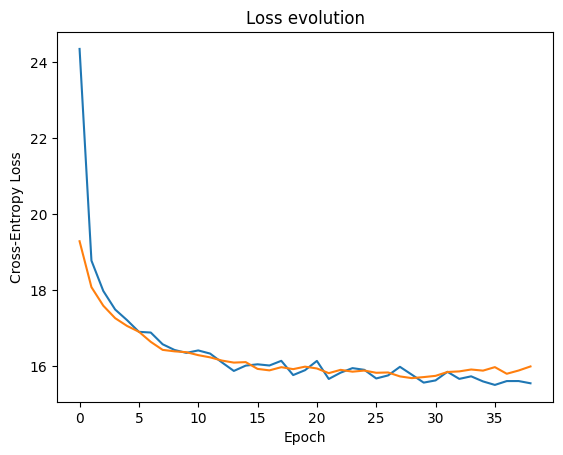

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss evolution')
plt.ylabel('Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.show()


This looks to have converged well.

In [14]:

preds = first_keras_model.predict(test[train_features.columns])
index = pd.read_csv('mimic_test_death.csv')
preds_df = pd.DataFrame({'icustay_id': index['icustay_id'], 'LOS': preds.flatten()})


# create file name with current timestamp
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'keras_attempt_' + timestr + '.csv'
preds_df.to_csv(filename, index=False)

164/164 [==============================] - 0s 2ms/step


### Hyperband Tuning Model V1


https://neptune.ai/blog/hyperband-and-bohb-understanding-state-of-the-art-hyperparameter-optimization-algorithms

This is a multifidelity hyperparameter optimization algorithm. My understanding is that is tests a partial model on a small subset of the data and then uses the results to decide whether to train the full model on the full dataset. The process is called successive halving. The rest is essentially grid search.

The hyperband hp allows you to freeze parameters for a model within a certain range, by using this logic we can create different models at different numbers of hidden layers, different numbers of units, different dropout rates, and different learning rates.

There is more complex tuning methods such as Bayesian optimization, and a combinatorial approach called BOHB, but this is a good starting point.

Notes on the optimization functions:

* leaky_relu compared to relu is more robust to noise and can accelerate the convergence of the training of deeper neural networks
* elu compared to relu can push the mean of the activations closer to zero, which can help accelerate convergence

In [15]:
def build_model(hp):

  model = Sequential()

  # 0.3 to 0.4
  hp_dropout_1 = hp.Float('rate', min_value=0.3, max_value=0.4, step=0.1)
  model.add(BatchNormalization())
  model.add(Dropout(hp_dropout_1, input_shape=(train_features.shape[1],)))

  '''
  iterations of tuning nodes in each layer
  '''
  hp_units = hp.Int('units_', min_value=16, max_value=128, step=16)

  # get max norm penalty for kernel for each layer
  # hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[4.0, 5.0, 7.0, 10.0, 100.0])
  hp_penalty = hp.Choice('maxnorm_kernel_constraint_', values=[3.0, 4.0, 5.0, 7.0])
  hp_kernel_reg_1 = hp.Choice('kernel_regularizer_1', values=[1e-5, 1e-4, 1e-3])
  hp_kernel_reg_2 = hp.Choice('kernel_regularizer_2', values=[1e-5, 1e-4, 1e-3])
  hp_bias_reg = hp.Choice('bias_regularizer_', values=[1e-5, 1e-4, 1e-3])

  # hp_activation_function = hp.Choice('activation_function_'+str(i), values=['relu','leaky_relu','elu'])
  hp_activation_function = hp.Choice('activation_function_', values=['relu','elu'])

  model.add(Dense(64, activation=hp_activation_function, input_shape=(train_features.shape[1],),
            kernel_regularizer=regularizers.l1_l2(l1=hp_kernel_reg_1, l2=hp_kernel_reg_2),
            bias_regularizer=regularizers.l2(hp_bias_reg),
            kernel_initializer=initializers.HeNormal(),
            bias_initializer=initializers.Zeros(),
            kernel_constraint=MaxNorm(hp_penalty)))
  model.add(BatchNormalization())

  # .3 to .5
  hp_dropout_2 = hp.Float('rate_', min_value=0.3, max_value=0.4, step=0.1)
  model.add(Dropout(hp_dropout_2))

  # Add dense output layer
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

In [16]:

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    min_delta=0.001,       # Minimum change to qualify as an improvement
    patience=10,           # How many epochs to wait before stopping
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored metric.
)

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3, # factor that determines the number of halvings in the successive halving
    directory='hyperband_model_2_tuning',
    project_name='keras_model'
)

tuner.search(train_features, train_labels, epochs=200, validation_split=0.2, callbacks=[early_stopping])


Reloading Tuner from hyperband_model_2_tuning/keras_model/tuner0.json


In [17]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


# Print the best hyperparameters
print('Best hyperparameters:', best_hyperparameters.values)


Best hyperparameters: {'rate': 0.3, 'units_': 96, 'maxnorm_kernel_constraint_': 4.0, 'kernel_regularizer_1': 0.0001, 'kernel_regularizer_2': 1e-05, 'bias_regularizer_': 1e-05, 'activation_function_': 'elu', 'rate_': 0.4, 'learning_rate': 0.01, 'tuner/epochs': 67, 'tuner/initial_epoch': 23, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0196'}


In [50]:

preds = best_model.predict(test[train_features.columns].values)
index = pd.read_csv('mimic_test_death.csv')
preds_df = pd.DataFrame({'icustay_id': index['icustay_id'], 'LOS': preds.flatten()})


# create file name with current timestamp
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'keras_hyperband_attempt_' + timestr + '.csv'
preds_df.to_csv(filename, index=False)

164/164 [==============================] - 0s 3ms/step


SHAP Tree

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations. In the SHAP Tree method, the SHAP values are calculated for each feature in the model. A SHAP value is calculated by taking the difference between the model output and the expected model output, given the feature value.

SHAP Deep Explainer

The SHAP Deep Explainer uses a gradient-based approach to explain the output of the model. It does this by approximating the SHAP values using a deep learning model rather than a linear model like the SHAP Tree method.

#### SHAP KernalExplainer

The SHAP Kernel Explainer uses a sampling approach to explain the output of the model. It does this by approximating the SHAP values using a linear regression model. 

Also none of the other explainers were working with my package versions and I was tired of fighting libraries. I will try to get them working in the future.

In [100]:
X_test = test[train_features.columns]

explainer = shap.KernelExplainer(best_model, X_test.iloc[:100,:])

shap_values = explainer.shap_values(X_test.iloc[:20,:], nsamples=500)
shap_values = np.squeeze(shap_values, axis=-1)


  0%|          | 0/20 [00:00<?, ?it/s]

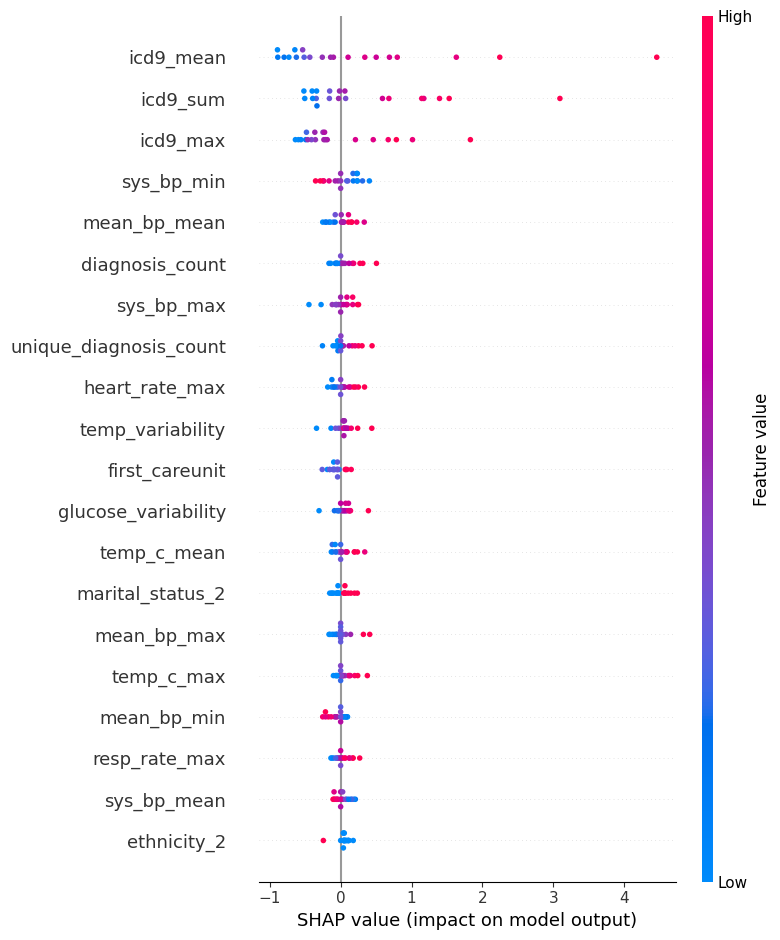

In [104]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_test.iloc[:20,:],
    feature_names=train_features.columns
)

Here we can see the top feature importances. The interesting part is the variance of the highest contributing features. Overall, there seems to be a correlation between the amount of variation in each variable, and the importance to the model.

In [106]:
shap.initjs()  # Necessary for visualization in Jupyter notebooks


shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:20,:])


Here we can see the 20 samples of data plotted with respect to the output value. There are a few key takeaways and most interesting is the age bin 5 variable that gains significance near the 4th shap value. Also interesting to note is the lack of variation in the low importance variables.

### Model V2

After reading a bit more about the hyperband tuning, I decided to try a different style model based on the kaggle I found below.

https://www.kaggle.com/code/msagmj/using-hyperparameter-tuned-keras-model-pycaret

Creating the model with a function

In [ ]:
def build_model(hp):

  model = Sequential()

  # 0.3 to 0.4
  hp_dropout_1 = hp.Float('rate', min_value=0.3, max_value=0.4, step=0.1)
  model.add(BatchNormalization())
  model.add(Dropout(hp_dropout_1, input_shape=(train_features.shape[1],)))

  # Tune the number of dense layers
  for i in range(hp.Int('num_layers', 1, 3)):


    '''
    iterations of tuning nodes in each layer
    '''
    # hp_units = hp.Int('units_'+str(i), min_value=10, max_value=200, step=10)
    # hp_units = hp.Int('units_'+str(i), min_value=350, max_value=550, step=50)
    # hp_units = hp.Int('units_'+str(i), min_value=440, max_value=520, step=10)
    # hp_units = hp.Int('units_'+str(i), min_value=440, max_value=490, step=10)
    hp_units = hp.Int('units_'+str(i), min_value=440, max_value=490, step=10)

    # get max norm penalty for kernel for each layer
    # hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[4.0, 5.0, 7.0, 10.0, 100.0])
    hp_penalty = hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[3.0, 4.0, 5.0, 7.0])

    # hp_activation_function = hp.Choice('activation_function_'+str(i), values=['relu','leaky_relu','elu'])
    hp_activation_function = hp.Choice('activation_function_'+str(i), values=['elu'])

    model.add(Dense(units=hp_units, activation=hp_activation_function, kernel_constraint=MaxNorm(max_value=hp_penalty)))
    model.add(BatchNormalization())


    # .3 to .5
    hp_dropout_2 = hp.Float('rate_'+str(i), min_value=0.3, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout_2))

  # Add dense output layer
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

Define early stopping and tuning

In [ ]:

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    min_delta=0.001,       # Minimum change to qualify as an improvement
    patience=10,           # How many epochs to wait before stopping
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored metric.
)

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3, # factor that determines the number of halvings in the successive halving
    directory='hyperband_tuning_1',
    project_name='keras_model'
)

tuner.search(train_features, train_labels, epochs=200, validation_split=0.2, callbacks=[early_stopping])


Reloading Tuner from hyperband_tuning_1/keras_model/tuner0.json


Got it working and it seems to be converging well.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Summary of the best model
best_model.summary()

# Print the best hyperparameters
print('Best hyperparameters:', best_hyperparameters.values)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 72)             │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 440)            │        32,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 440)            │         1,760 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 440)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 470)            │       207,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 470)            │         1,880 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 470)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 490)            │       230,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 490)            │         1,960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 490)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           491 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,559 (1.82 MB)

 Trainable params: 473,615 (1.81 MB)

 Non-trainable params: 2,944 (11.50 KB)

Best hyperparameters: {'rate': 0.3, 'num_layers': 3, 'units_0': 440, 'maxnorm_kernel_constraint_0': 4.0, 'activation_function_0': 'elu', 'rate_0': 0.3, 'learning_rate': 0.001, 'units_1': 470, 'maxnorm_kernel_constraint_1': 7.0, 'activation_function_1': 'elu', 'rate_1': 0.3, 'units_2': 490, 'maxnorm_kernel_constraint_2': 4.0, 'activation_function_2': 'leaky_relu', 'rate_2': 0.4, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0143'}


Predict the model results

In [ ]:

preds = best_model.predict(test[train_features.columns])
index = pd.read_csv('data/mimic_test_death.csv')
preds_df = pd.DataFrame({'icustay_id': index['icustay_id'], 'LOS': preds.flatten()})


# create file name with current timestamp
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'submissions/keras_hyperband_attempt_' + timestr + '.csv'
preds_df.to_csv(filename, index=False)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


This model worked pretty well at 4.1 but took a long time to work, and had marginal improvements on the first model. 

### Model V3

I didnt yet get to run this one, but this would be cool to see with a LLM and the train data. 

In [107]:
from transformers import AutoTokenizer, TFAutoModel
import os

checkpoint = "distilbert-base-uncased"

# Optionally, clear the cache or specify a different cache directory
cache_dir = "./transformers_cache"  # New cache directory
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=cache_dir)
model = TFAutoModel.from_pretrained(checkpoint, cache_dir=cache_dir)

batch_size=64
max_length=64
rate = 0.5 # dropout parameters
num_labels = 2

steps_per_epoch = int(len(text_features) / batch_size)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [109]:

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

metadata_input = tf.keras.layers.Input(shape=(train_features.shape[1],), name='metadata_input')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)

# we need only the first token representation nothing else from the last layer!
final_embedding_layer = embedding_layer[0]#last layer of BERT

# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
bert_output = tf.keras.layers.Dense(64,
                               activation='relu')(output_layer)

# *** adding a input layer for the meta data
metadata_dense = tf.keras.layers.Dense(64, activation='relu')(metadata_input)

# *** combine metadata and other layer
combined = tf.keras.layers.concatenate([bert_output, metadata_dense])

combined_layer = tf.keras.layers.Dense(64, activation='relu')(combined)


output_layer = tf.keras.layers.Dense(num_labels, activation='linear')(combined_layer)


bert_model_meta = tf.keras.Model(inputs=[input_ids_in, input_masks_in, metadata_input], outputs = output_layer)



bert_model_meta.summary()

TypeError: Exception encountered when calling layer 'embeddings' (type TFEmbeddings).

Could not build a TypeSpec for name: "tf.debugging.assert_less_1/assert_less/Assert/Assert"
op: "Assert"
input: "tf.debugging.assert_less_1/assert_less/All"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_0"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_1"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_2"
input: "Placeholder"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_4"
input: "tf.debugging.assert_less_1/assert_less/y"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}
 of unsupported type <class 'tensorflow.python.framework.ops.Operation'>.

Call arguments received by layer 'embeddings' (type TFEmbeddings):
  • input_ids=<KerasTensor: shape=(None, 64) dtype=int32 (created by layer 'input_token')>
  • position_ids=None
  • inputs_embeds=None
  • training=False

In [110]:

def get_batches_w_meta(X_train, X_meta, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size], X_meta[i:i + batch_size]], y_train[i:i + batch_size]

In [ ]:
text_features

0        Hemorrhage of gastrointestinal tract, unspecif...
1        Eosinophilic esophagitis Foreign body in esoph...
2        Perforation of intestine Other suppurative per...
3        Diaphragmatic hernia without mention of obstru...
4        Diverticulitis of colon (without mention of he...
                               ...                        
20880    Meningitis, unspecified Grand mal status Acute...
20881    Malignant neoplasm of other parts of brain Cer...
20882    Secondary diabetes mellitus with other specifi...
20883    Coronary atherosclerosis of native coronary ar...
20884    Benign neoplasm of liver and biliary passages ...
Name: all_text, Length: 20885, dtype: object

In [ ]:

batches = get_batches_w_meta(text_features, np.array(train_features), train_labels, tokenizer, batch_size, max_length)


bert_model_meta.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
bert_model_meta.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element of shape (64,) where an element of shape (None, None) was expected.
Traceback (most recent call last):

  File "/Users/andrewbennett/Documents/bse/term2/comp_learning_deep_learning/test2/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/Users/andrewbennett/Documents/bse/term2/comp_learning_deep_learning/test2/.venv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/andrewbennett/Documents/bse/term2/comp_learning_deep_learning/test2/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (64,) where an element of shape (None, None) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_58052]